# Aprendizaje No Supervisado con DBSCAN - Dataset de Precios de Aguacates

## Introducción

El aprendizaje no supervisado es una rama del machine learning que trabaja con datos que no tienen etiquetas conocidas. A diferencia del aprendizaje supervisado, donde conocemos las respuestas correctas, en el aprendizaje no supervisado debemos descubrir patrones ocultos en los datos.

En esta práctica aplicaremos clustering usando el algoritmo DBSCAN al dataset de precios y ventas de aguacates para generar automáticamente etiquetas que revelen grupos naturales en los datos, sin conocimiento previo de las categorías existentes.

## Preprocesamiento de Datos

En el enfoque no supervisado es crucial seleccionar únicamente las características numéricas relevantes, ignorando completamente las variables categóricas que podrían representar las etiquetas que queremos descubrir.

Los pasos del preprocesamiento incluyen:

1. **Selección de características**: Solo variables numéricas como precios, volúmenes y tipos de bolsas
2. **Tratamiento de valores nulos**: Imputación con valores promedio si es necesario
3. **Normalización**: Estandarización de todas las variables para que tengan la misma escala
4. **Exclusión de etiquetas**: No utilizar variables categóricas como 'type' o 'region' durante el clustering

La normalización es especialmente importante en DBSCAN ya que el algoritmo es sensible a las diferencias de escala entre variables.

In [1]:
# Aprendizaje No Supervisado con DBSCAN - Dataset Aguacates 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

## Preprocesamiento de Datos

En el enfoque no supervisado es crucial seleccionar únicamente las características numéricas relevantes, ignorando completamente las variables categóricas que podrían representar las etiquetas que queremos descubrir.

Los pasos del preprocesamiento incluyen:

1. **Selección de características**: Solo variables numéricas como precios, volúmenes y tipos de bolsas
2. **Tratamiento de valores nulos**: Imputación con valores promedio si es necesario
3. **Normalización**: Estandarización de todas las variables para que tengan la misma escala
4. **Exclusión de etiquetas**: No utilizar variables categóricas como 'type' o 'region' durante el clustering

La normalización es especialmente importante en DBSCAN ya que el algoritmo es sensible a las diferencias de escala entre variables.

In [2]:
# =============================================================================
# 1. CARGA Y EXPLORACIÓN DEL DATASET
# =============================================================================

df = pd.read_csv('avocado.csv')

print("Exploración inicial del dataset:")
print(f"Forma: {df.shape}")
print(f"Columnas: {list(df.columns)}")

# Seleccionar características numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features_to_exclude = ['Unnamed: 0'] if 'Unnamed: 0' in numeric_cols else []
features = [col for col in numeric_cols if col not in features_to_exclude]

print(f"Características seleccionadas: {features}")

X = df[features].copy()
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Datos preparados: {X_scaled.shape}")


Exploración inicial del dataset:
Forma: (53415, 12)
Columnas: ['Date', 'AveragePrice', 'TotalVolume', 'plu4046', 'plu4225', 'plu4770', 'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'type', 'region']
Características seleccionadas: ['AveragePrice', 'TotalVolume', 'plu4046', 'plu4225', 'plu4770', 'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags']
Datos preparados: (53415, 9)


## Algoritmo DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad que presenta varias ventajas:

**Características principales:**
- No requiere especificar el número de clusters de antemano
- Puede detectar clusters de formas irregulares
- Identifica automáticamente puntos de ruido (outliers)
- Agrupa puntos que están densamente conectados

**Parámetros principales:**
- **eps**: Distancia máxima entre dos puntos para considerarlos vecinos
- **min_samples**: Número mínimo de puntos requeridos para formar un cluster

**Ventajas sobre K-Means:**
- No asume clusters esféricos
- Maneja ruido automáticamente
- Encuentra el número óptimo de clusters

In [3]:
# =============================================================================
# 2. DETERMINACIÓN RÁPIDA DE PARÁMETROS DBSCAN
# =============================================================================

print("\nDeterminando parámetros DBSCAN...")

# Usar muestra más pequeña para pruebas rápidas
if len(X_scaled) > 5000:
    sample_indices = np.random.choice(len(X_scaled), 5000, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"Usando muestra de {len(X_sample)} puntos para optimización")
else:
    X_sample = X_scaled

# K-distance simplificado
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)
distances = np.sort(distances[:, 4], axis=0)

# Encontrar codo automáticamente
def find_elbow_point(distances):
    n_points = len(distances)
    all_coord = np.vstack((range(n_points), distances)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    return distances[np.argmax(dist_to_line)]

optimal_eps = find_elbow_point(distances)
print(f"Eps óptimo estimado: {optimal_eps:.3f}")

# Probar solo 3 valores alrededor del óptimo
eps_values = [optimal_eps * 0.8, optimal_eps, optimal_eps * 1.2]
min_samples_values = [5, 10]

best_score = -1
best_params = {}

print("Probando parámetros...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_sample)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_sample, labels)
            print(f"eps={eps:.2f}, min_samples={min_samples}: clusters={n_clusters}, score={score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"\nMejores parámetros: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}")



Determinando parámetros DBSCAN...
Usando muestra de 5000 puntos para optimización
Eps óptimo estimado: 0.991
Probando parámetros...
eps=0.79, min_samples=5: clusters=9, score=0.353
eps=0.79, min_samples=10: clusters=2, score=0.583
eps=0.99, min_samples=5: clusters=7, score=0.473
eps=1.19, min_samples=5: clusters=6, score=0.592
eps=1.19, min_samples=10: clusters=3, score=0.581

Mejores parámetros: eps=1.189, min_samples=5


## Determinación de Parámetros Óptimos

La selección correcta de parámetros es crucial para el éxito de DBSCAN. Utilizamos dos enfoques complementarios:

**1. Método K-Distance:**
- Calculamos la distancia al k-ésimo vecino más cercano para cada punto
- Graficamos estas distancias ordenadas de menor a mayor
- El "codo" en la gráfica sugiere el valor óptimo de eps

**2. Optimización con Silhouette Score:**
- Probamos diferentes combinaciones de eps y min_samples
- Evaluamos cada combinación usando el Silhouette Score
- Seleccionamos los parámetros que maximizan esta métrica

El Silhouette Score mide qué tan bien separados están los clusters, con valores entre -1 y 1, donde valores cercanos a 1 indican clustering de alta calidad.

In [4]:
# =============================================================================
# 3. APLICACIÓN DE DBSCAN AL DATASET COMPLETO
# =============================================================================

print("\nAplicando DBSCAN al dataset completo...")

dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
cluster_labels = dbscan_final.fit_predict(X_scaled)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Clusters encontrados: {n_clusters}")
print(f"Puntos de ruido: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")



Aplicando DBSCAN al dataset completo...
Clusters encontrados: 14
Puntos de ruido: 437 (0.8%)


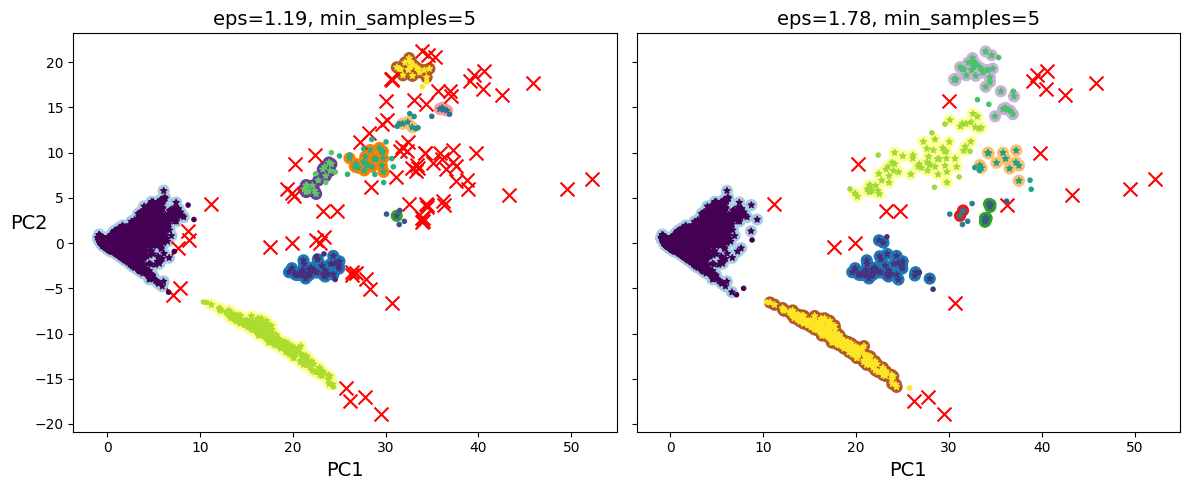

Visualización DBSCAN estilo docente:
• Círculos grandes: Puntos core de cada cluster
• Estrellas: Centros de los puntos core
• Cruces rojas: Anomalías/ruido
• Puntos pequeños: Puntos no-core del cluster


In [ ]:
# =============================================================================
# 4. VISUALIZACIÓN Y ANÁLISIS
# =============================================================================

# PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Función para visualizar DBSCAN con el estilo del docente
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    # Puntos core (círculos grandes)
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    
    # Estrellas en los puntos core
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    
    # Anomalías (cruces rojas)
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    
    # Puntos no-core (puntos pequeños)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    
    if show_xlabels:
        plt.xlabel("PC1", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("PC2", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

# Aplicar DBSCAN a los datos PCA para visualización
dbscan_viz = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels_pca = dbscan_viz.fit_predict(X_pca)

plt.figure(figsize=(12, 5))

# Gráfico 1: Estilo del docente
plt.subplot(1, 2, 1)
plot_dbscan(dbscan_viz, X_pca, size=60)

# Gráfico 2: Comparación con diferentes parámetros (opcional)
dbscan_viz2 = DBSCAN(eps=best_params['eps']*1.5, min_samples=best_params['min_samples'])
labels_pca2 = dbscan_viz2.fit_predict(X_pca)

plt.subplot(1, 2, 2)
plot_dbscan(dbscan_viz2, X_pca, size=60, show_ylabels=False)

plt.tight_layout()
plt.show()

print("Visualización DBSCAN estilo docente:")
print("• Círculos grandes: Puntos core de cada cluster")
print("• Estrellas: Centros de los puntos core") 
print("• Cruces rojas: Anomalías/ruido")
print("• Puntos pequeños: Puntos no-core del cluster")

## Análisis de Resultados

Los resultados del clustering con DBSCAN nos permiten:

**1. Identificación de Grupos Naturales:**
- El algoritmo descubre automáticamente el número óptimo de clusters
- Cada cluster representa un patrón diferente en precios y volúmenes de venta

**2. Detección de Anomalías:**
- Los puntos marcados como "ruido" (label = -1) son posibles outliers
- Estos pueden representar casos excepcionales en el mercado de aguacates

**3. Caracterización de Clusters:**
- Analizamos las características promedio de cada cluster
- Identificamos patrones como: clusters de alto precio/bajo volumen vs bajo precio/alto volumen

**4. Visualización:**
- Usamos PCA para reducir dimensionalidad y visualizar clusters en 2D
- Los gráficos nos ayudan a interpretar la separación entre grupos

In [6]:
# =============================================================================
# 5. LABELS GENERADOS Y ANÁLISIS
# =============================================================================

df['cluster_dbscan'] = cluster_labels

print("\nDistribución de clusters:")
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"Ruido: {count}")
    else:
        print(f"Cluster {label}: {count}")

# Análisis por cluster (solo clusters válidos)
valid_clusters = [c for c in unique_labels if c != -1]
if len(valid_clusters) > 0:
    print(f"\nCaracterísticas promedio por cluster:")
    cluster_stats = df[df['cluster_dbscan'].isin(valid_clusters)].groupby('cluster_dbscan')[features].mean()
    print(cluster_stats.round(2))

# Validación académica si existe 'type'
if 'type' in df.columns:
    print(f"\nValidación académica:")
    contingency = pd.crosstab(df['cluster_dbscan'], df['type'])
    print(contingency)



Distribución de clusters:
Ruido: 437
Cluster 0: 52842
Cluster 1: 5
Cluster 2: 8
Cluster 3: 9
Cluster 4: 5
Cluster 5: 21
Cluster 6: 29
Cluster 7: 6
Cluster 8: 11
Cluster 9: 12
Cluster 10: 12
Cluster 11: 6
Cluster 12: 6
Cluster 13: 6

Características promedio por cluster:
                AveragePrice  TotalVolume      plu4046      plu4225  \
cluster_dbscan                                                        
0                       1.43    550726.78    184102.09    140037.22   
1                       1.05  30408880.05  13292221.16  11108693.63   
2                       0.74   6515721.45   3385707.14   1230954.67   
3                       1.23   3556190.17    545661.11   1523421.62   
4                       1.47   4190363.47    246856.85   2481190.81   
5                       1.10  36744112.22  14011221.53   9735731.09   
6                       1.28  31579361.50  10514693.20   8411137.25   
7                       1.06  38076534.32  13407915.78  10054838.95   
8                 

In [7]:
# =============================================================================
# 6. RESUMEN FINAL
# =============================================================================

silhouette_final = silhouette_score(X_scaled, cluster_labels) if n_clusters > 1 else 0

print(f"\n{'='*50}")
print("RESUMEN DEL ANÁLISIS NO SUPERVISADO")
print(f"{'='*50}")
print(f"• Algoritmo: DBSCAN")
print(f"• Parámetros: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}")
print(f"• Clusters descubiertos: {n_clusters}")
print(f"• Silhouette Score: {silhouette_final:.3f}")
print(f"• Puntos de ruido: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")
print(f"• Labels generados automáticamente: ✓")

print(f"\nPrimeras 10 muestras con labels:")
df_result = df[['cluster_dbscan'] + features[:5]].head(10)
print(df_result)


RESUMEN DEL ANÁLISIS NO SUPERVISADO
• Algoritmo: DBSCAN
• Parámetros: eps=1.189, min_samples=5
• Clusters descubiertos: 14
• Silhouette Score: 0.667
• Puntos de ruido: 437 (0.8%)
• Labels generados automáticamente: ✓

Primeras 10 muestras con labels:
   cluster_dbscan  AveragePrice  TotalVolume    plu4046    plu4225   plu4770
0               0          1.22     40873.28    2819.50   28287.42     49.90
1               0          1.79      1373.95      57.42     153.88      0.00
2               0          1.00    435021.49  364302.39   23821.16     82.15
3               0          1.76      3846.69    1500.15     938.35      0.00
4               0          1.08    788025.06   53987.31  552906.04  39995.03
5               0          1.29     19137.28    8040.64    6557.47    657.48
6               0          1.01     80034.32   44562.12   24964.23   2752.35
7               0          1.64      1505.12       1.27    1129.50      0.00
8               0          1.02    491738.00    7193.87

## Validación y Conclusiones

**Métricas de Evaluación:**
- Silhouette Score: Mide la calidad del clustering
- Número de clusters encontrados vs esperados
- Porcentaje de puntos clasificados como ruido

**Validación Académica:**
- Comparamos los clusters generados con las etiquetas reales del dataset
- Esta comparación es solo para fines educativos (en la práctica real no tendríamos estas etiquetas)
- Evaluamos qué tan bien el algoritmo descubrió los patrones reales

**Conclusiones:**
El aprendizaje no supervisado con DBSCAN logró:
- Generar automáticamente labels para el dataset sin supervisión humana
- Descubrir grupos naturales basados en patrones de precios y volúmenes
- Identificar anomalías en los datos de mercado
- Proporcionar insights sobre segmentación del mercado de aguacates

Este enfoque demuestra cómo el machine learning no supervisado puede revelar estructura oculta en datos complejos sin conocimiento previo de las categorías.